In [40]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import arff
from scipy.optimize import minimize, Bounds
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from umap.umap_ import UMAP
from time import time

random.seed(0)
np.random.seed(0)

In [41]:
data, meta = arff.loadarff('/Users/alv.popov/study/ml/data/spam.arff')
data[:10]

array([(0.  , 0.64, 0.64, 0., 0.32, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  , 0.  , 0.32, 0.  , 1.29, 1.93, 0.  , 0.96, 0., 0.  , 0.  , 0., 0., 0., 0., 0., 0., 0., 0., 0.  , 0., 0., 0., 0.  , 0., 0., 0.  , 0., 0., 0.  , 0.  , 0.  , 0.  , 0., 0., 0.  , 0.   , 0., 0.778, 0.   , 0.   , 3.756,  61.,  278., b'1'),
       (0.21, 0.28, 0.5 , 0., 0.14, 0.28, 0.21, 0.07, 0.  , 0.94, 0.21, 0.79, 0.65, 0.21, 0.14, 0.14, 0.07, 0.28, 3.47, 0.  , 1.59, 0., 0.43, 0.43, 0., 0., 0., 0., 0., 0., 0., 0., 0.  , 0., 0., 0., 0.07, 0., 0., 0.  , 0., 0., 0.  , 0.  , 0.  , 0.  , 0., 0., 0.  , 0.132, 0., 0.372, 0.18 , 0.048, 5.114, 101., 1028., b'1'),
       (0.06, 0.  , 0.71, 0., 1.23, 0.19, 0.19, 0.12, 0.64, 0.25, 0.38, 0.45, 0.12, 0.  , 1.75, 0.06, 0.06, 1.03, 1.36, 0.32, 0.51, 0., 1.16, 0.06, 0., 0., 0., 0., 0., 0., 0., 0., 0.  , 0., 0., 0., 0.  , 0., 0., 0.06, 0., 0., 0.12, 0.  , 0.06, 0.06, 0., 0., 0.01, 0.143, 0., 0.276, 0.184, 0.01 , 9.821, 485., 2259., b'1'),
       (0.  , 0.  , 0.  , 0., 0

In [42]:
target = "class"
x_names = meta.names().copy()
x_names.remove(target)
x, y = pd.DataFrame(data[x_names]).to_numpy(), data[target]

y[y == b'1'] = 1
y[y == b'0'] = 0
y = y.astype(int)
y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [43]:
def validate(model) -> float:
    kf = KFold(shuffle=True, random_state=0)
    stat = []
    for train, test in kf.split(x, y):
        model.fit(x[train], y[train])
        y_pred = model.predict(x[test])
        mse = f1_score(y[test], y_pred)
        stat.append(mse)
    return sum(stat) / len(stat)

validate(RandomForestClassifier())

0.9424758297645333

In [44]:
# реализовать байесовскую оптимизацию RandomForestRegressor

# правую границу включаем
params_constraints = {
    'n_estimators': ('int', (1, 1000)),
    'max_depth': ('int', (1, len(data))),
    'min_samples_split': ('int', (2, len(data))),
    'min_samples_leaf': ('int', (1, len(data))),
    'max_features': ('int', (1, len(data[0]) - 1)),
    'max_leaf_nodes': ('int', (2, len(data))),
}

lb, rb = [], []
for _, constraint in params_constraints.values():
    lb.append(constraint[0])
    rb.append(constraint[1])
bounds = Bounds(lb, rb)

def random_params():
    params = {}
    for name, info in params_constraints.items():
        if info[0] == 'int':
            a, b = info[1]
            params[name] = np.random.randint(a, b + 1)
        else:
            raise NotImplementedError(f'Type {info[0]} not implemented yet')
    return params

def calc_score(params) -> float:
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        max_leaf_nodes=params['max_leaf_nodes'],
    )
    return validate(model)

class BayesianOptimizer:

    d_meta_ = []
    def _add_meta_item(self, params, score):
        params_score = list(params.values())
        params_score.append(score)
        self.d_meta_.append(params_score)

    _gpr = GaussianProcessRegressor(random_state=0)

    best_try = None

    def _fit(self):
        arr = np.asarray(self.d_meta_)
        params, score = arr[:, :-1], arr[:, -1]
        self._gpr.fit(params, score)

    def _ei(self, params, eps=0.01) -> float:
        params = list(map(int, params))
        mu, sigma = self._gpr.predict([params], return_std=True)
        mu, sigma = mu[0], sigma[0]
        best_score = self.best_try['score']
        a = mu - best_score - eps
        if np.isclose(sigma, 0):
            print('sigma 0')
        b = a / sigma
        return a * norm.cdf(b) + sigma * norm.pdf(b)

    def _calc_score(self, params):
        score = calc_score(params)
        if self.best_try is None or score > self.best_try['score']:
            self.best_try = {'params': params, 'score': score}
        return score

    def _maximize_ei(self, n_restarts=25):
        mn = None
        for _ in range(n_restarts):
            res = minimize(
                fun=lambda params: -self._ei(params),
                x0=np.fromiter(random_params().values(), dtype=float),
                bounds=bounds,
                method='L-BFGS-B',
            )
            if mn is None or res.fun < mn[0]:
                mn = (res.fun, res.x)
        return dict((k, int(v)) for k, v in zip(self.best_try['params'].keys(), mn[1]))

    def __init__(self, n_initial=3):
        for _ in range(n_initial):
            params = random_params()
            score = self._calc_score(params)
            self._add_meta_item(params, score)
        self._fit()

    def optimize(self, n_iter=100):
        for _ in tqdm(range(n_iter)):
            params = self._maximize_ei()
            score = self._calc_score(params)
            self._add_meta_item(params, score)
            self._fit()
        return self.best_try

In [45]:
# сравнить бо со случайным поиском
n = 500
bo_time = time()
bo = BayesianOptimizer(n_initial=3)
best_bo_score = bo.optimize(n_iter=n-3)['score']
bo_time = time() - bo_time
bo_meta = np.asarray(bo.d_meta_)

rs_time = time()
rs_meta = []
for i in tqdm(range(n)):
    params_map = random_params()
    score1 = calc_score(params_map)
    row = list(params_map.values())
    row.append(score1)
    rs_meta.append(row)
best_rs_score = np.asarray(rs_meta)[:, -1].max()
rs_time = time() - rs_time
rs_meta = np.asarray(rs_meta)

print("--- f-score for 100 iterations ---")
print(f"bayesian optimization: time {bo_time} score {best_bo_score}")
print(f"random search: time {rs_time} score {best_rs_score}")

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

--- f-score for 100 iterations ---
bayesian optimization: time 2017.000685930252 score 0.8972354890540652
random search: time 1865.9007830619812 score 0.8660873658502217


/var/folders/3s/h732c42d1jn2zbf_qxt6wv540000gq/T/ipykernel_82461/882936183.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


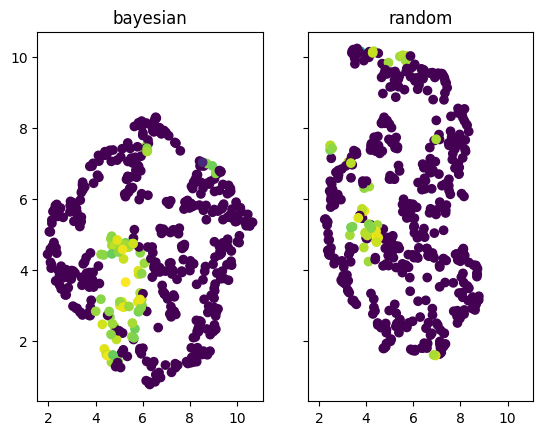

In [46]:
# визуализировать значение от гиперпараметров для бо и сп
bo_embedding = UMAP(random_state=0).fit_transform(bo_meta[:, :-1])
rs_embedding = UMAP(random_state=0).fit_transform(rs_meta[:, :-1])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex='all', sharey='all')
ax1.scatter(
    bo_embedding[:, 0],
    bo_embedding[:, 1],
    c=bo_meta[:, -1]
)
ax1.title.set_text('bayesian')

ax2.scatter(
    rs_embedding[:, 0],
    rs_embedding[:, 1],
    c=rs_meta[:, -1]
)
ax2.title.set_text('random')

fig.show()

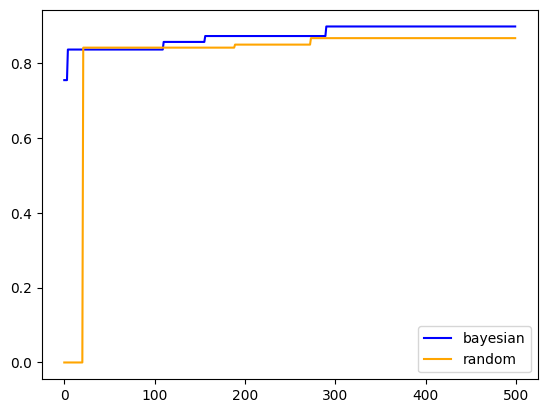

In [47]:
# визуализировать значение от номера шага для бо и сп
# кумулятивный максимум
def cumulative_max(arr):
    res = [arr[0]]
    for v in arr[1:]:
        res.append(max(v, res[-1]))
    return res

plt.plot(cumulative_max(bo_meta[:, -1]), color='blue')
plt.plot(cumulative_max(rs_meta[:, -1]), color='orange')
plt.legend(['bayesian', 'random'])
plt.show()